**Tensorflow implementation** of the paper [Steerable discovery of neural audio effects](https://arxiv.org/abs/2112.02926) by [Christian J. Steinmetz](https://www.christiansteinmetz.com/) and [Joshua D. Reiss](http://www.eecs.qmul.ac.uk/~josh/)

______________________________________________

<div align="center">

# Steerable discovery of neural audio effects

  [Christian J. Steinmetz](https://www.christiansteinmetz.com/)  and  [Joshua D. Reiss](http://www.eecs.qmul.ac.uk/~josh/)


[Code](https://github.com/csteinmetz1/steerable-nafx) • [Paper](https://arxiv.org/abs/2112.02926) • [Demo](https://csteinmetz1.github.io/steerable-nafx)	• [Slides]()

<img src="https://csteinmetz1.github.io/steerable-nafx/assets/steerable-headline.svg">

</div>

## Abtract
Applications of deep learning for audio effects often focus on modeling analog effects or learning to control effects to emulate a trained audio engineer. 
However, deep learning approaches also have the potential to expand creativity through neural audio effects that enable new sound transformations. 
While recent work demonstrated that neural networks with random weights produce compelling audio effects, control of these effects is limited and unintuitive.
To address this, we introduce a method for the steerable discovery of neural audio effects.
This method enables the design of effects using example recordings provided by the user. 
We demonstrate how this method produces an effect similar to the target effect, along with interesting inaccuracies, while also providing perceptually relevant controls.


\* *Accepted to NeurIPS 2021 Workshop on Machine Learning for Creativity and Design*



# Setup

In [1]:
import numpy as np
import scipy as sp

import tensorflow as tf
from tensorflow import keras

import os
import IPython

import matplotlib.pyplot as plt
import librosa.display

2024-01-18 19:40:02.671042: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 19:40:02.671064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 19:40:02.671881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 19:40:02.676579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 19:40:03.385747: W tensorflow/compiler/tf2

### Choose computation device

In [2]:
physical_devices = tf.config.list_physical_devices()
print(f"These are the physical devices available:\n{physical_devices}")

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    print(f"These are the visible devices:\n{visible_devices}")
except:
    pass

These are the physical devices available:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
These are the visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
name = 'model_0'


if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

A model with the same name already exists. Please choose a new name.


## Define the model

In [4]:
keras.backend.clear_session()

class TCNBlock(keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, activation=True, **kwargs):
        super().__init__(**kwargs)
        self.conv = keras.layers.Conv1D(filters=out_channels, kernel_size=kernel_size, dilation_rate=dilation, padding="valid", use_bias=True)
        if activation:
            self.act = tf.keras.activations.tanh
        self.res = keras.layers.Conv1D(out_channels, 1, use_bias=False)
        self.kernel_size = kernel_size
        self.dilation = dilation

    def call(self, x):
        x_in = x
        x = self.conv(x)
        if hasattr(self, 'act'):
            x = self.act(x)
        x_res = self.res(x_in)
        x_res = x_res[:, (self.kernel_size-1)*self.dilation:, :]
        x = x + x_res
        return x
    
class TCN(keras.Model):
    def __init__(self, n_inputs=1, n_outputs=1, n_blocks=10, kernel_size=13, n_channels=64, dilation_growth=4):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_channels = n_channels
        self.dilation_growth = dilation_growth
        self.n_blocks = n_blocks
        self.stack_size = n_blocks
        
        self.blocks = []
        for n in range(n_blocks):
            if n == 0:
                in_ch = n_inputs
                out_ch = n_channels
                act = True
            elif (n+1) == n_blocks:
                in_ch = n_channels
                out_ch = n_outputs
                act = True
            else:
                in_ch = n_channels
                out_ch = n_channels
                act = True

            dilation = dilation_growth ** n
            self.blocks.append(TCNBlock(in_ch, out_ch, kernel_size, dilation, activation=act))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def compute_receptive_field(self):
        """Compute the receptive field in samples."""
        rf = self.kernel_size
        for n in range(1, self.n_blocks):
            dilation = self.dilation_growth ** (n % self.stack_size)
            rf = rf + ((self.kernel_size - 1) * dilation)
        return rf

# 1. Steering (training)
Use a pair of audio examples in order to construct neural audio effects.

There are two options. Either start with the pre-loaded audio examples, or upload your own clean/processed audio recordings for the steering process.

a.) Use some of our pre-loaded audio examples. Choose from the compressor or reverb effect.

In [5]:
#@title Use pre-loaded audio examples for steering
effect_type = "UltraTab" #@param ["Compressor", "Reverb", "UltraTab"]

if effect_type == "Compressor":
  input_file = "audio/drum_kit_clean.wav"
  output_file = "audio/drum_kit_comp_agg.wav"
elif effect_type == "Reverb":
  input_file = "audio/acgtr_clean.wav"
  output_file = "audio/acgtr_reverb.wav"
elif effect_type == "UltraTab":
  input_file = "audio/acgtr_clean.wav"
  output_file = "audio/acgtr_ultratab.wav"


# Load and Preprocess Data ###########################################
sample_rate, x = sp.io.wavfile.read(input_file)
sample_rate, y = sp.io.wavfile.read(output_file)

x = x.astype(np.float32)
y = y.astype(np.float32)

x = x[..., :1]/32768.0 # because wav files are 16-bit integers
y = y[..., :1]/32768.0

x = x.flatten()
y = y.flatten()

print(f"x shape: {x.shape}")
print(f"x = {x}")
print(f"y shape: {y.shape}")
print(f"y = {y}")

print("input file", x.shape)
IPython.display.display(IPython.display.Audio(data=x, rate=sample_rate))
print("output file", y.shape)
IPython.display.display(IPython.display.Audio(data=y, rate=sample_rate))

x shape: (508032,)
x = [-3.0517578e-05 -3.0517578e-05 -3.0517578e-05 ...  9.3383789e-03
  2.8991699e-03  0.0000000e+00]
y shape: (508032,)
y = [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
 -6.1035156e-05 -9.1552734e-05]
input file (508032,)


/tmp/ipykernel_9986/3624094671.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x = sp.io.wavfile.read(input_file)


output file (508032,)


Now its time to generate the neural audio effect by training the TCN to emulate the input/output function from the target audio effect. Adjusting the parameters will enable you to tweak the optimization process. 

In [6]:
#@title TCN model training parameters
kernel_size = 13 #@param {type:"slider", min:3, max:32, step:1}
n_blocks = 4 #@param {type:"slider", min:2, max:30, step:1}
dilation_growth = 10 #@param {type:"slider", min:1, max:10, step:1}
n_channels = 32 #@param {type:"slider", min:1, max:128, step:1}
n_iters = 300 #@param {type:"slider", min:0, max:10000, step:1}
length = 228308 #@param {type:"slider", min:0, max:524288, step:1}
lr = 0.001 #@param {type:"number"}

# # reshape the audio
x_batch = x.reshape(1,-1,1)
y_batch = y.reshape(1,-1,1)

print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

# build the model
model = TCN(
    n_inputs=1,
    n_outputs=1,
    kernel_size=kernel_size, 
    n_blocks=n_blocks, 
    dilation_growth=dilation_growth, 
    n_channels=n_channels)
rf = model.compute_receptive_field()

print(f"Receptive field: {rf} samples or {(rf/sample_rate)*1e3:0.1f} ms")

x_batch shape: (1, 508032, 1)
y_batch shape: (1, 508032, 1)
Receptive field: 13333 samples or 302.3 ms


In [7]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, n_iters):
        self.initial_learning_rate = initial_learning_rate
        self.n_iters = n_iters

    @tf.function
    def __call__(self, step):
        if step >= tf.cast((self.n_iters * 0.8), tf.int64):
            return self.initial_learning_rate * 0.1
        elif step >= tf.cast(self.n_iters * 0.95, tf.int64):
            return self.initial_learning_rate * 0.01
        else:
            return self.initial_learning_rate
        
    def get_config(self):
        config = {
        'initial_learning_rate': self.initial_learning_rate,
        'niters': self.n_iters,
        }
        return config

optimizer = keras.optimizers.Adam(learning_rate=MyLRSchedule(lr, n_iters), epsilon=1e-8)
model.compile(optimizer=optimizer, loss='mse')
model.build(input_shape=(None, length+rf-1, 1))
model.summary(expand_nested=True)

Model: "tcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_block (TCNBlock)        multiple                  480       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)            multiple                  448      |
|                                                               |
| conv1d_1 (Conv1D)          multiple                  32       |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 tcn_block_1 (TCNBlock)      multiple                  14368     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d_2 (Conv1D)          multiple                  13344    |
|                                                               |
| conv1d_3 (Conv1D)          multiple                  1024     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 tcn_block_2 (TCNBlock)      multiple                  14368   

## Train the model

In [8]:
start_idx = rf 
stop_idx = start_idx + length

# the data is the same with every iteration
x_crop = x_batch[:,start_idx-rf+1:stop_idx,:]
y_crop = y_batch[:,start_idx:stop_idx,:]
print(f"x_crop = {x_crop.shape}")
print(f"y_crop = {y_crop.shape}")

history = model.fit(x=x_crop, y=y_crop, epochs=n_iters, batch_size=1, verbose=1)

x_crop = (1, 241640, 1)
y_crop = (1, 228308, 1)
Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 0.0091
Epoch 2/300
1/1 [==============================] - 1s 551ms/step - loss: 0.0058
Epoch 3/300
1/1 [==============================] - 1s 508ms/step - loss: 0.0039
Epoch 4/300
1/1 [==============================] - 1s 544ms/step - loss: 0.0039
Epoch 5/300
1/1 [==============================] - 1s 539ms/step - loss: 0.0038
Epoch 6/300
1/1 [==============================] - 1s 542ms/step - loss: 0.0032
Epoch 7/300
1/1 [==============================] - 1s 510ms/step - loss: 0.0026
Epoch 8/300
1/1 [==============================] - 1s 538ms/step - loss: 0.0023
Epoch 9/300
1/1 [==============================] - 1s 564ms/step - loss: 0.0024
Epoch 10/300
1/1 [==============================] - 1s 546ms/step - loss: 0.0024
Epoch 11/300
1/1 [==============================] - 1s 513ms/step - loss: 0.0023
Epoch 12/300
1/1 [==============================] - 1s 672ms/step - loss:

In [9]:
model.save_weights('models/'+name+'/'+name)

## Run predictions
### 0. Load the model

In [10]:
model.load_weights('models/'+name+'/'+name)

### 1. On the test audio data

1/1 [==============================] - 0s 415ms/step
Input shape: (508032,)
Output shape: (508032,)
Target shape: (508032,)
Input (clean)


Target


Output


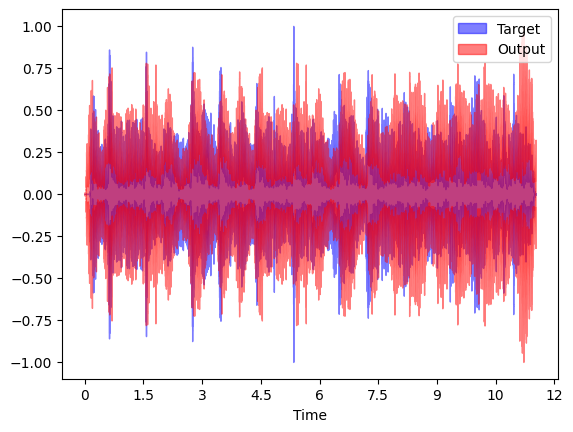

In [11]:
# Run Prediction #################################################
# Test the model on the testing data #############################

x_pad = np.pad(x_batch, ((0,0),(rf-1,0),(0,0)), mode='constant')

y_hat = model.predict(x_pad)

input = x_batch.flatten()
output = y_hat.flatten()
target = y_batch.flatten()

print(f"Input shape: {input.shape}")
print(f"Output shape: {output.shape}")
print(f"Target shape: {target.shape}")

# apply highpass to outpu to remove DC
sos = sp.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
output = sp.signal.sosfilt(sos, output)

input /= np.max(np.abs(input))
output /= np.max(np.abs(output))
target /= np.max(np.abs(target))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(target, sr=sample_rate, color='b', alpha=0.5, ax=ax, label='Target')
librosa.display.waveshow(output, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')

print("Input (clean)")
IPython.display.display(IPython.display.Audio(data=input, rate=sample_rate))
print("Target")
IPython.display.display(IPython.display.Audio(data=target, rate=sample_rate))
print("Output")
IPython.display.display(IPython.display.Audio(data=output, rate=sample_rate))
plt.legend()
plt.show(fig)

/tmp/ipykernel_9986/1344136279.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, x_whole = sp.io.wavfile.read("audio/piano_clean.wav")


1/1 [==============================] - 0s 442ms/step


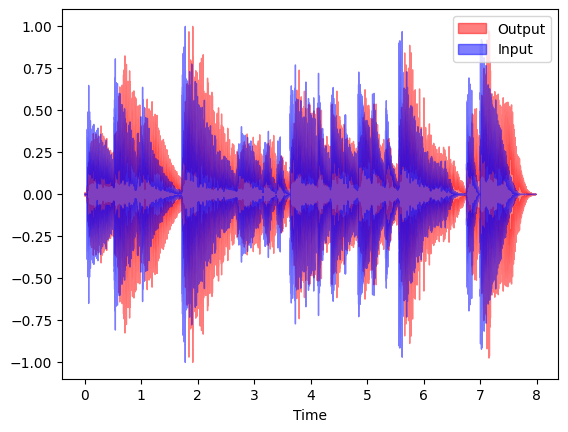

In [12]:
# Load and Preprocess Data ###########################################
sample_rate, x_whole = sp.io.wavfile.read("audio/piano_clean.wav")
x_whole = x_whole.astype(np.float32)
x_whole = x_whole[..., :1]/32768.0 # because wav files are 16-bit integers
x_whole = x_whole.reshape(1,-1,1)

# Padding on both sides of the receptive field
x_whole = np.pad(x_whole, ((0,0),(rf-1,rf-1),(0,0)), mode='constant')

y_whole = model.predict(x_whole)

x_whole = x_whole[:, -y_whole.shape[1]:, :]

y_whole /= np.abs(y_whole).max()

# apply high pass filter to remove DC
sos = sp.signal.butter(8, 20.0, fs=sample_rate, output="sos", btype="highpass")
y_whole = sp.signal.sosfilt(sos, y_whole.flatten())

x_whole = x_whole.flatten()

y_whole = (y_whole * 0.8)
IPython.display.display(IPython.display.Audio(data=x_whole, rate=sample_rate))
IPython.display.display(IPython.display.Audio(data=y_whole, rate=sample_rate))

x_whole /= np.max(np.abs(x_whole))
y_whole /= np.max(np.abs(y_whole))

fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y_whole, sr=sample_rate, color='r', alpha=0.5, ax=ax, label='Output')
librosa.display.waveshow(x_whole, sr=sample_rate, alpha=0.5, ax=ax, label='Input', color="blue")
plt.legend()
plt.show(fig)

### 2. On a number sequence (to control inference)

In [13]:
# Test the model simple number sequence to compare with inference #
X_testing_2 = np.array([])

for i in range(0, 2048+rf-1):
    X_testing_2 = np.append(X_testing_2, i*0.000001)

X_testing_2 = X_testing_2.reshape(1, -1, 1)

print("Running prediction..")
prediction_2 = model.predict(X_testing_2)
print(f"prediction {prediction_2}")

print("X_testing_2 shape: ", X_testing_2.shape)
print("prediction_2 shape: ", prediction_2.shape)

Running prediction..
1/1 [==============================] - 0s 18ms/step
prediction [[[0.00632703]
  [0.00632768]
  [0.00632833]
  ...
  [0.00765621]
  [0.00765686]
  [0.00765751]]]
X_testing_2 shape:  (1, 15380, 1)
prediction_2 shape:  (1, 2048, 1)


## Export as tflite and onnx model

In [14]:
buffer_size = 2048
# rf is the receptive field and hence the kernel size of the last layer because of the dilation
# hence the model input size needs to be at least rf
model_input_size = buffer_size+rf-1
input_shape = [None, model_input_size, 1]

func = tf.function(model).get_concrete_function(
    tf.TensorSpec(input_shape, dtype=tf.float32))
converter = tf.lite.TFLiteConverter.from_concrete_functions([func], model)
tflite_model = converter.convert()

# Save the model.
with open("models/"+name+"/"+"steerable-nafx.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6w7p7uha/assets


INFO:tensorflow:Assets written to: /tmp/tmp6w7p7uha/assets
2024-01-18 19:43:47.296457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-18 19:43:47.296475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-18 19:43:47.296961: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6w7p7uha
2024-01-18 19:43:47.298575: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-18 19:43:47.298584: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6w7p7uha
2024-01-18 19:43:47.302337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-18 19:43:47.303676: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-18 19:43:47.350179: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [15]:
import tf2onnx
import onnx

buffer_size = 2048
# rf is the receptive field and hence the kernel size of the last layer because of the dilation
# hence the model input size needs to be at least rf
model_input_size = buffer_size+rf-1
input_shape = [None, model_input_size, 1]

# Define the input shape
input_signature = [tf.TensorSpec(input_shape, tf.float32, name='x')]

# Convert the model
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(proto=onnx_model, f="models/"+name+"/"+"steerable-nafx-tflite"+".onnx")

2024-01-18 19:43:48.019143: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-01-18 19:43:48.019222: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-01-18 19:43:48.220726: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-01-18 19:43:48.220805: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
